In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

# Mean Fill

In [2]:
# clean data
train = pd.read_csv('./data.csv') # 训练集的读取
train1 = train
train1=train1.fillna(train1.mean())
train1=train1.fillna('None') 
print('train set is filled with mean/none, sum NA=', sum(train1.isnull().sum()))

# build train set
y = train1['SalePrice']
train1 = train1.drop(['Id', 'SalePrice'], axis=1)
X=pd.get_dummies(train1) # Convert categorical variable into dummy/indicator variables

# train the model 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123)
print('set is splited into train, test:', X_train.shape, X_test.shape)
xg_reg = xgb.XGBRegressor(objective='reg:linear',
                          colsample_bytree=0.6,
                          learning_rate=0.01,
                          max_depth=8,
                          alpha=10,
                          n_estimators=700,
                          subsample=0.7,
                          random_state=123)
xg_reg.fit(X_train,y_train)

# model valuation 
pred = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,pred))
logrmse = np.sqrt(mean_squared_error(np.log(y_test),np.log(pred)))
print('rmse:', rmse, 'logrmse:', logrmse)

train set is filled with mean/none, sum NA= 0
set is splited into train, test: (1168, 303) (292, 303)
rmse: 24397.005804359607 logrmse: 0.11291591685262999


# Median Fill py27

In [3]:
# clean data
train = pd.read_csv('./data.csv') # 训练集的读取
train1 = train
train1=train1.fillna(train1.median())
train1=train1.fillna('None') 
print('train set is filled with mean/none, sum NA=', sum(train1.isnull().sum()))

# build train set
y = train1['SalePrice']
train1 = train1.drop(['Id', 'SalePrice'], axis=1)
X=pd.get_dummies(train1) # Convert categorical variable into dummy/indicator variables
#默认情况只对category and ojbect 进行 onehot 编码
# train the model 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=123)
print('set is splited into train, test:', X_train.shape, X_test.shape)
xg_reg = xgb.XGBRegressor(objective='reg:linear',
                          colsample_bytree=0.6,
                          learning_rate=0.01,
                          max_depth=8,
                          alpha=10,
                          n_estimators=700,
                          subsample=0.7,
                          random_state=123)
xg_reg.fit(X_train,y_train)

# model valuation 
pred = xg_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,pred))
logrmse = np.sqrt(mean_squared_error(np.log(y_test),np.log(pred)))
print('rmse:', rmse, 'logrmse:', logrmse)

train set is filled with mean/none, sum NA= 0
set is splited into train, test: (1168, 303) (292, 303)
rmse: 24377.995089907552 logrmse: 0.1129396317760244


### Grid Search

In [4]:
gs = GridSearch(xg_reg, {
    "n_estimators:":[100, 500, 1000, 3000],
    "alpha:":[0.01, 0.1, 1.0, 10],
    "lambda":[...]
})
# 可能重复搜索

NameError: name 'GridSearch' is not defined

### Randomized Search 

In [ ]:
gs = RandomizedSearch(xg_reg, {
    "n_estimators:":[100, 500, 1000, 3000],
    "alpha:":np.norm(1.0, 0.7),
    "lambda":[...]
})

In [ ]:
print(train1.shape, X_train.shape, X_test.shape)

## 交叉验证

1. 数据有限 ->发挥数据本来的效率

2. 数据的训练集和评测集的矛盾
      
      * 如果用更多的数据去训练，那么就会有更少的数据来评测->失去了对于真实泛化能力的考量
      * 如果用胜少的数据来训练，很大可能造成欠拟合，在评测集上表现就一定不好

解决办法：
1. 将数据集拆成k份->(首先进行shuffle)
2. 规定k-1份进行训练，剩下1份进行评测，总共训练k次，轮流每个子数据集作为评测集
    数据集被分成k份， 1....k
    第1次训练使用第1份数据作为评测集，剩余的k-1份作为训练集
    第i次训练使用第i份数据作为评测集，剩余的k-1份作为训练集
    做k次训练

3. k次训练之后，评测的分值=k次评测结果的平均
4. 不同的模型会提供不同的子模型合并方法，会将所有k个子模型进行合并

In [ ]:
params = {"objective":"reg:linear",
          "cosample_bytree":0.7,
         'learning_rate':0.1,
         'max_depth':10,
         'alpha':10}

In [ ]:
matrix = xgb.DMatrix(data=X, label=y)#xgboost 可以接受的Data的一种压缩后的数据结构. lmdb/.h5

In [ ]:
cv_results = xgb.cv(params=params, 
       nfold=10, 
       num_boost_round=500, 
       metrics='rmse',
       as_pandas=True,
       dtrain = matrix)
#决策树的学习过程分为两个阶段，分裂和剪枝(前剪枝和后见剪枝)
cv_results.iloc[:,-2]

## 数据的EDA入门

1. 数据属性分布分析(概率密度分析/是否呈现正态分布)
2. 数据属性与Target之间的相关性
3. 缺失属性相关性分析--进行合理的填充
4. 构造属性和构造属性的相关性分析

## 相关性分析
[-1, +1]

|r| > 0.95 显著关系

|r| >=0.8 强相关

|r| >=0.5 中度相关

0.5 >= |r| >= 0.3 弱相关（待挖掘，可以尝试去掉) 部分数据与该特征可能存在较强相关性。(楼房屋顶和顶楼的成交价格)

|r| < 0.3 极弱相关

In [ ]:
corr = train.corr()['SalePrice']

In [ ]:
corr = train.corr()['SalePrice']
corr[(corr>0.5) | (corr < -.5)].sort_values()

In [ ]:
corr[corr>0.5]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
plt.figure(figsize=(30,30))
sns.heatmap(train.corr(), linewidth=-.01, square=True, cmap='viridis', annot=True)

In [ ]:
plt.figure(figsize=(30,30))
sns.heatmap(train.corr(), linewidth=-.01, square=True, cmap='viridis', annot=True)

## 特征观察

观察特征与目标值之间的关系（使用统计图来进行观察)

In [ ]:
corr = train.corr()['SalePrice']
corr[corr>0.5].sort_values()

In [ ]:
train[['OverallQual','SalePrice']].groupby(['OverallQual']).mean().plot.bar()

### 'GarageCars' 与 ‘SalePrice' 之间的关系

In [ ]:
train[['GarageCars', 'SalePrice']].groupby(['GarageCars']).mean().plot.bar()

In [ ]:
train[['GarageArea', 'SalePrice']].groupby(['GarageArea']).mean().plot.bar()
#不要将连续的数据进行groupby 这样没有意义， 如果想要对连续型数据进行grouby，需要对该数据进行分段。



In [6]:
# 正相关数据分析
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


# OerallQual 与 SalePrice 的相关性分析

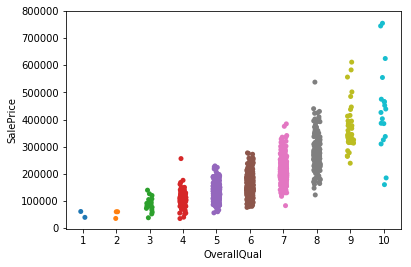

In [7]:
sns.stripplot('OverallQual', 'SalePrice',data=train)

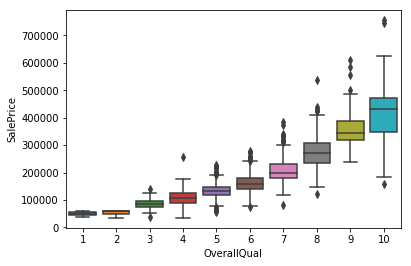

In [8]:
sns.boxplot('OverallQual', 'SalePrice',data=train)

#### 作业： 分析 SalePrice 与 corr>0.5 的变量的关系，以及corr< 0的变量的关系，请说明分析理由。

scatter, jointplot

### 新一轮空值填充

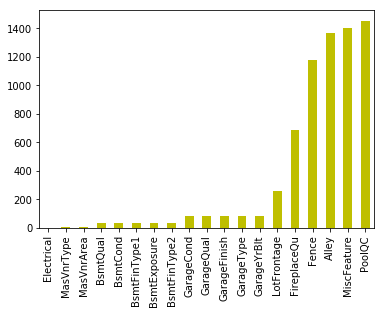

In [9]:
x = train.isnull().sum()
x[x>0].sort_values().plot.bar(color='y')

In [ ]:
### LotFrontage 的填充
思路1：去不同的Neighborhood的均值和中位数

C:\Users\lizhi\Anaconda2\envs\py36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


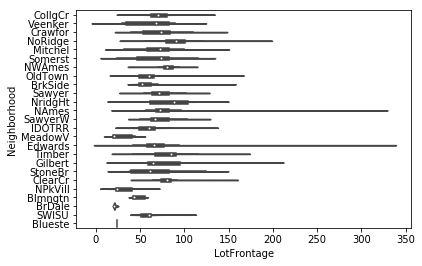

In [10]:
sns.violinplot(train['LotFrontage'], train['Neighborhood'])

In [13]:
neighborhood_group=train.groupby('Neighborhood')
lot_medians=neighborhood_group['LotFrontage'].median()
lot_means =neighborhood_group['LotFrontage'].mean()
lot_means

Neighborhood
Blmngtn    47.142857
Blueste    24.000000
BrDale     21.562500
BrkSide    57.509804
ClearCr    83.461538
CollgCr    71.682540
Crawfor    71.804878
Edwards    68.217391
Gilbert    79.877551
IDOTRR     62.500000
MeadowV    27.800000
Mitchel    70.083333
NAmes      76.462366
NPkVill    32.285714
NWAmes     81.288889
NoRidge    91.878788
NridgHt    81.881579
OldTown    62.788991
SWISU      58.913043
Sawyer     74.437500
SawyerW    71.500000
Somerst    64.666667
StoneBr    62.700000
Timber     80.133333
Veenker    59.714286
Name: LotFrontage, dtype: float64

In [14]:
train[train['LotFrontage'].isnull()]['Neighborhood']

7        NWAmes
12       Sawyer
14        NAmes
16        NAmes
24       Sawyer
31       Sawyer
42      SawyerW
43      CollgCr
50      Gilbert
64      CollgCr
66        NAmes
76        NAmes
84      Gilbert
95      Gilbert
100      NWAmes
104      IDOTRR
111     Gilbert
113     Crawfor
116      Sawyer
120     ClearCr
126     NPkVill
131     Gilbert
133      Timber
136       NAmes
147     Gilbert
149     BrkSide
152      NWAmes
153     ClearCr
160     Veenker
166     ClearCr
         ...   
1300    Gilbert
1301    Crawfor
1309    SawyerW
1312    NoRidge
1318    CollgCr
1321    BrkSide
1342    CollgCr
1346     NWAmes
1348    SawyerW
1354    CollgCr
1356      NAmes
1357      NAmes
1358    Somerst
1362      NAmes
1365    Somerst
1368    CollgCr
1373    NoRidge
1381      NAmes
1383     Sawyer
1396     Timber
1407    Mitchel
1417    NoRidge
1419    Crawfor
1423    Edwards
1424      NAmes
1429     NWAmes
1431    NPkVill
1441    CollgCr
1443    BrkSide
1446    Mitchel
Name: Neighborhood, Leng

## 思路二
通过LotArea进行填充

In [15]:
train['LotFrontage'].corr(train['LotArea'])

0.4260950187718077

In [24]:
train['LotFrontage'].corr(np.sqrt(train['LotArea']))

0.602002216793936

In [26]:
train['SqrtLotArea']=np.sqrt(train['LotArea'])

In [27]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,SqrtLotArea
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,91.923882
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,97.979590
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,106.066017
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,97.724101
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,119.415242


C:\Users\lizhi\Anaconda2\envs\py36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


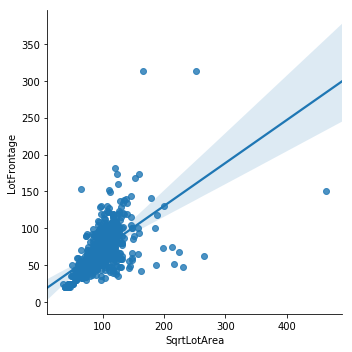

In [28]:
sns.lmplot('SqrtLotArea', 'LotFrontage', data=train)

C:\Users\lizhi\Anaconda2\envs\py36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


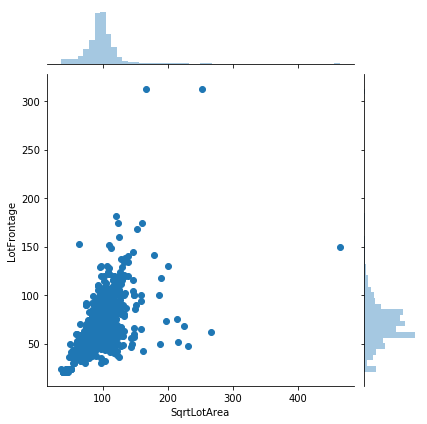

In [29]:
sns.jointplot('SqrtLotArea', 'LotFrontage', data=train)

In [30]:
filter = train['LotFrontage'].isnull()
train.LotFrontage[filter]=0.6 * train.SqrtLotArea[filter]

C:\Users\lizhi\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [31]:
filter = train['LotFrontage'].isnull()
filter

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
1430    False
1431    False
1432    False
1433    False
1434    False
1435    False
1436    False
1437    False
1438    False
1439    False
1440    False
1441    False
1442    False
1443    False
1444    False
1445    False
1446    False
1447    False
1448    False
1449    False
1450    False
1451    False
1452    False
1453    False
1454    False
1455    False
1456    False
1457    False
1458    False
1459    False
Name: LotFrontage, Length: 1460, dtype: bool